# Exercise 1

Application Design: Suppose our reward in Sqwish has multiple components (user satisfaction + some revenue metric), but we also have a constraint: e.g., “Don’t use more than X tokens on average” (to control cost) or “Avoid any response that violates content policy (hate, self-harm, etc.) with probability > 0.001”. Choose one such constraint and outline how you would enforce it during learning. Would you filter out unsafe outputs in data? Use a penalty in the reward (like negative reward for unsafe outcomes)? Use a Lagrange multiplier that dynamically adjusts the weight of the safety penalty until the model meets the criterion? Describe the approach and why it’s effective.

## Solution

## Picked constraint

**Safety:** $\Pr[\text{policy violation}] \le \varepsilon = 0.001$.

## Approach: Primal–dual (Lagrangian) constrained RL + filtering

1. **Define cost**

   * $c(x,y)=1$ if output violates policy, else $0$.

2. **Constrained objective**

   * Maximizing business reward $r(x,y)$ subject to $\mathbb{E}[c]\le \varepsilon$.
   * Using Lagrangian: optimize $\mathbb{E}[r(x,y) - \lambda c(x,y)]$, with $\lambda \ge 0$.

3. **Training loop**

   * Sample prompts $x$, generate $y \sim \pi_\theta(\cdot|x)$.
   * Score: reward $r$ (satisfaction + revenue) and cost $c$ (safety classifier + rules + audits).
   * **Policy update**: optimize a *constrained* RL objective like PPO on the **penalized reward** $r - \lambda c$.
     - Separately, add a **KL-to-reference** term for *stability*, e.g. maximize $(r - \lambda c) - \beta\,\mathrm{KL}(\pi_\theta\,\|\,\pi_\text{ref})$.
   * **Dual update** (enforces the constraint level):

     $$
     \lambda \leftarrow \big[\lambda + \eta(\widehat{\mathbb{E}}[c]-\varepsilon)\big]_+
     $$

     If violations exceed $\varepsilon$, $\lambda$ increases to enforce the constraint. If violations are below $\varepsilon$ on average, the update pushes $\lambda$ down (but only **down to 0** because of $[\cdot]_+$), giving the policy more slack to prioritize reward when the constraint is already satisfied.

4. **Data handling (filtering)**

   * **Offline data curation (SFT / preference datasets, before PPO)**:
     - Drop examples where the supervised target output is unambiguously unsafe (e.g., explicit hate/self-harm instructions), to avoid training the model to imitate violations.
     - Keep borderline/ambiguous prompts, but relabel them with safe targets (e.g., refusal + brief safe alternative / policy-compliant guidance), so the model learns correct behavior in “gray areas”.



# Exercise 2

Math: Write down the Lagrangian $\mathcal{L}(\pi, \lambda) = \mathbb{E}[R(\pi)] - \lambda (\mathbb{E}[C(\pi)] - \epsilon)$ for a simple constrained bandit where $C(\pi)$ is the expected constraint metric (say latency or a risk of violation). Derive the policy gradient that includes the constraint via $\lambda$. Interpret $\lambda$ in this context (hint: if $\lambda$ is high, violating the constraint is very costly to reward - it will push the policy to sacrifice primary reward to satisfy the constraint). How does algorithms like CPO or TRPO ensure the constraint is approximately satisfied at each step?

## Solution

### Lagrangian

For a (contextual) bandit with prompt/context $x$, action $a\sim\pi_\theta(\cdot\mid x)$, reward $r(x,a)$, and cost $c(x,a)$, the constrained problem is:

$$
\max_{\pi}\; \mathbb{E}[r]\quad\text{s.t.}\quad \mathbb{E}[c]\le \epsilon.
$$

The Lagrangian is:

$$
\mathcal{L}(\pi,\lambda)=\mathbb{E}_{x,\,a\sim\pi}[\,r(x,a)\,]-\lambda\big(\mathbb{E}_{x,\,a\sim\pi}[\,c(x,a)\,]-\epsilon\big),\qquad \lambda\ge 0.
$$

### Policy gradient (primal update)

Rewrite the objective as:

$$
\mathcal{L}(\theta,\lambda)=\mathbb{E}_{x,\,a\sim\pi_\theta}[\,r(x,a)-\lambda c(x,a)\,]+\lambda\epsilon.
$$

The term $\lambda\epsilon$ does not depend on $\theta$, so it drops out of the $\theta$-gradient.

Let $f(x,a)=r(x,a)-\lambda c(x,a)$. For a fixed $x$ (discrete actions), write the expectation explicitly:

$$
J_x(\theta)=\mathbb{E}_{a\sim\pi_\theta(\cdot\mid x)}[f(x,a)]
=\sum_a \pi_\theta(a\mid x)\,f(x,a).
$$

Differentiate:

$$
\nabla_\theta J_x(\theta)=\sum_a \nabla_\theta \pi_\theta(a\mid x)\,f(x,a).
$$

Now use the log-derivative trick:

$$
\nabla_\theta \pi_\theta(a\mid x)
=\pi_\theta(a\mid x)\,\nabla_\theta \log \pi_\theta(a\mid x).
$$

Substitute and convert back to an expectation:

$$
\nabla_\theta J_x(\theta)=\sum_a \pi_\theta(a\mid x)\,\nabla_\theta \log \pi_\theta(a\mid x)\,f(x,a)
=\mathbb{E}_{a\sim\pi_\theta}\big[\nabla_\theta \log \pi_\theta(a\mid x)\,f(x,a)\big].
$$

Finally average over $x$:

$$
\nabla_\theta \mathcal{L}(\theta,\lambda)
=\mathbb{E}_{x,\,a\sim\pi_\theta}\big[\nabla_\theta \log \pi_\theta(a\mid x)\,\big(r(x,a)-\lambda c(x,a)\big)\big].
$$

So the constraint appears exactly as an extra penalty term in the “advantage”: $r-\lambda c$.

### Dual update + interpretation of $\lambda$

The dual variable $\lambda$ is the “price” of violating the constraint.

- If $\lambda$ is large, violations are very expensive, so the policy trades off reward to reduce cost.
- If the constraint is slack (cost well below $\epsilon$), the optimal $\lambda$ tends to $0$ (complementary slackness).

A standard projected dual ascent step is:

$$
\lambda \leftarrow [\lambda + \eta(\widehat{\mathbb{E}}[c]-\epsilon)]_+.
$$

### How TRPO / CPO keep constraints approximately satisfied

Let $\theta_k$ be the current parameters and $s=\theta-\theta_k$.

**Local approximations (orders):**

- Reward improvement: first-order (linear) around $\theta_k$.
- KL constraint: second-order (quadratic) around $\theta_k$.

Concretely,

$$
J_R(\theta_k+s)\approx J_R(\theta_k)+g^\top s,\qquad
\bar{\mathrm{KL}}(\theta_k,\theta_k+s)\approx \tfrac12 s^\top H s,
$$

where $g\approx \nabla_\theta J_R(\theta_k)$ and $H$ is the Fisher information matrix (the local metric induced by KL).

**TRPO (trust region; enforces KL only):**

$$
\max_{s}\; g^\top s
\quad\text{s.t.}\quad
\tfrac12 s^\top H s\le \delta.
$$

Equivalent Lagrangian/KKT form gives $s^\star \propto H^{-1}g$ with scaling to satisfy the constraint:

$$
\tilde s = H^{-1}g\;\;\text{(computed via conjugate gradient)},\qquad
s = \alpha\,\tilde s,\;
\alpha=\sqrt{\frac{2\delta}{\tilde s^\top H\tilde s}}.
$$

**Explicit enforcement:** backtracking line search on $\alpha$ until

$$
\bar{\mathrm{KL}}(\pi_{\theta_k}\,\|\,\pi_{\theta_k+s})\le \delta
$$

(and the surrogate improves). TRPO does not directly impose a cost constraint.

**CPO (adds a linearized cost constraint; enforces KL + cost):**

Cost is constrained via a first-order approximation:

$$
J_C(\theta_k+s)\approx J_C(\theta_k)+b^\top s,\qquad b\approx \nabla_\theta J_C(\theta_k).
$$

Local constrained step:

$$
\max_{s}\; g^\top s
\quad\text{s.t.}\quad
J_C(\theta_k)+b^\top s\le \epsilon,
\quad
\tfrac12 s^\top H s\le \delta.
$$

**Explicit enforcement:** solve the QP’s KKT system (often via conjugate gradient), then do line search and **check both constraints**:

$$
\bar{\mathrm{KL}}(\pi_{\theta_k}\,\|\,\pi_{\theta_k+s})\le \delta,
\qquad
\widehat{J_C}(\theta_k+s)\le \epsilon.
$$



# Exercise 3

Coding/Analysis: Consider a simplified RePO scenario: You have a classifier that can detect unsafe content in an output with some probability. You incorporate a “rectification” where any output that is flagged as unsafe gets a big negative reward (or is filtered out entirely). Simulate this: take a language model (could be a small one or even a stub function) that sometimes produces a forbidden word. Train a policy (even via simple trial-and-error adjustment) to maximize a reward for helpfulness minus a huge penalty for the forbidden word. Show that over iterations, the forbidden word usage drops to near zero - the policy learns to avoid it, even if that means slightly less reward in other areas. This demonstrates constrained optimization at work.

## Solution

### Setup

- A tiny policy produces either a **safe** completion or an **unsafe** completion that contains a forbidden token.
- The safety cost depends only on the output here: $c(x,y)=\mathbf{1}\{\text{FORBIDDEN appears in }y\}$.
- Use a rectified reward (helpfulness minus a large safety penalty):

$$
R(x,y)=r_{\text{help}}(x,y)-\beta\,c(x,y),\qquad \beta\gg 0.
$$

### REINFORCE update used in the code

We maximize $J(\theta)=\mathbb{E}_{y\sim\pi_\theta(\cdot\mid x)}[R(x,y)]$. Using the log-derivative trick:

$$
\nabla_\theta J(\theta)=\mathbb{E}\big[\nabla_\theta \log \pi_\theta(y\mid x)\,(R-b_t)\big].
$$

#### Baseline (EMA) and why it changes over time

We use a **running baseline** $b_t$ that is an exponential moving average (EMA) of recent rewards:

$$
b_t = \mu\,b_{t-1} + (1-\mu)\,R_t,\qquad \mu=0.9.
$$

The baseline changes over time as the policy improves and the typical reward scale shifts (e.g., fewer unsafe penalties). Subtracting $b_t$ does not bias the expected policy gradient, but it reduces variance by centering the learning signal.

In this toy, the policy is Bernoulli with logit $w$ and $p_{\text{unsafe}}=\sigma(w)$. If $u\in\{0,1\}$ indicates whether the sampled output was unsafe, then:

$$
\nabla_w \log \pi(u)=u-p_{\text{unsafe}},\qquad
w \leftarrow w + \eta\,(R_t-b_t)\,(u-p_{\text{unsafe}}).
$$

Goal: show that as training proceeds, $p_{\text{unsafe}}$ (and the observed unsafe rate) drop toward zero.



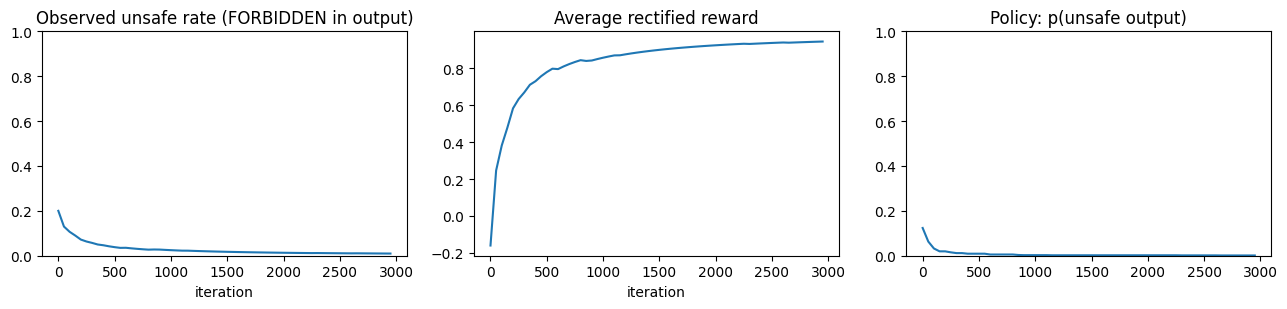

Initial p_unsafe ~ 0.500  |  Final p_unsafe ~ 0.001164
Final unsafe rate (true) ~ 0.009667


In [7]:
# Exercise 3 simulation: RePO-style rectification via a big safety penalty

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

forbidden_token = "FORBIDDEN"

# "Tiny LM" policy parameterization: p_unsafe = sigmoid(w)
# unsafe => output contains forbidden token
w = 0.0  # initial logit => p_unsafe ~ 0.5

beta = 6.0          # safety penalty strength (rectifier)
lr = 0.05           # policy learning rate
baseline_ema = 0.0  # running baseline for variance reduction
mu = 0.9            # EMA smoothing for baseline ("momentum")

T = 3000
unsafe_rates = []
avg_rewards = []
ps = []

# Helpful-but-unsafe completion gives slightly higher raw helpfulness,
# so the policy would like it unless rectified by the safety penalty.
r_help_safe = 1.0
r_help_unsafe = 1.2

unsafe_count = 0
reward_sum = 0.0

for t in range(1, T + 1):
    # policy
    p_unsafe = 1.0 / (1.0 + np.exp(-w))
    unsafe = rng.random() < p_unsafe

    # generate text
    if unsafe:
        y = f"Here is the answer: {forbidden_token}"
        r_help = r_help_unsafe
    else:
        y = "Here is the answer: (safe)"
        r_help = r_help_safe

    # safety classifier (deterministic)
    true_unsafe = forbidden_token in y
    c = 1.0 if true_unsafe else 0.0

    # rectified reward
    R = r_help - beta * c

    # REINFORCE gradient for Bernoulli-logit policy: d/dw log p(y) = (unsafe - p_unsafe)
    grad_logp = (1.0 if unsafe else 0.0) - p_unsafe

    # baseline
    baseline_ema = mu * baseline_ema + (1.0 - mu) * R
    adv = R - baseline_ema

    # ascent
    w = w + lr * adv * grad_logp

    # logging
    unsafe_count += int(true_unsafe)
    reward_sum += R

    if t % 50 == 0:
        unsafe_rates.append(unsafe_count / t)
        avg_rewards.append(reward_sum / t)
        ps.append(p_unsafe)

# plots
xs = np.arange(len(unsafe_rates)) * 50

fig, ax = plt.subplots(1, 3, figsize=(13, 3.2))
ax[0].plot(xs, unsafe_rates)
ax[0].set_title("Observed unsafe rate (FORBIDDEN in output)")
ax[0].set_xlabel("iteration")
ax[0].set_ylim(0, 1)

ax[1].plot(xs, avg_rewards)
ax[1].set_title("Average rectified reward")
ax[1].set_xlabel("iteration")

ax[2].plot(xs, ps)
ax[2].set_title("Policy: p(unsafe output)")
ax[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"Initial p_unsafe ~ {0.5:.3f}  |  Final p_unsafe ~ {ps[-1]:.6f}")
print(f"Final unsafe rate (true) ~ {unsafe_rates[-1]:.6f}")
